In [2]:
"""
Deep CNN model for Pneumonia detection in X-ray images. 
Code adapted from https://www.kaggle.com/madz2000
Densenet201 Architecture with added Fully Connected blocks
Accuracy of the model: 94.39%
Ideas for improvement: 
- K-fold validation for a better measure of the stochastic variance.
- Imbalanced dataset leading to poor results on "Normal" images. Add more images to this class
- Use callbacks such as EarlyStopping, ReduceLROnPlateau and Modelcheckpoint to improve model performance
"""

'\nDeep CNN model for Pneumonia detection in X-ray images. \nArchitecture: Densenet201\nAccuracy of the model: 91.83 %\n\n'

In [3]:
# Import necessary libraries 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras import Input
from keras.applications import DenseNet201
from keras.models import Model 
from keras.initializers import he_normal
from keras.layers import Concatenate, Lambda, Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import cv2
import os


In [4]:
# Loading dataset 

labels = ['PNEUMONIA', 'NORMAL']
img_size = 150 

def load_data(data_dir):
  data = []
  for label in labels:
    path = os.path.join(data_dir, label)
    class_num = labels.index(label)
    for img in os.listdir(path):
      try: 
        img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        resized_arr = cv2.resize(img_arr, (img_size, img_size))
        data.append([resized_arr, class_num])
      except Exception as e:
        print(e)
  return np.array(data)


In [5]:
# Execute Load data from google drive folder to Colab

train = load_data('/content/drive/MyDrive/Colab Notebooks/input/chest_xray/chest_xray/train')
test = load_data('/content/drive/MyDrive/Colab Notebooks/input/chest_xray/chest_xray/test')
val = load_data('/content/drive/MyDrive/Colab Notebooks/input/chest_xray/chest_xray/val')


OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


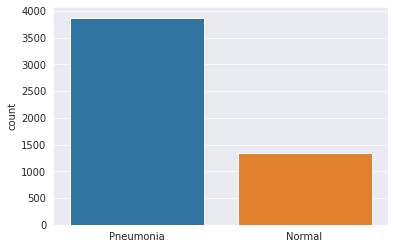

In [6]:
# Visualise data to see count of each image class
# The number of Pneumonia images to Normal images is imbalanced, so we'll use data augmentation in the following cell

l = []
for i in train:
  if(i[1] == 0):
    l.append("Pneumonia")
  else:
    l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

Text(0.5, 1.0, 'NORMAL')

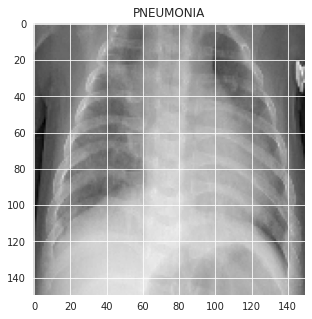

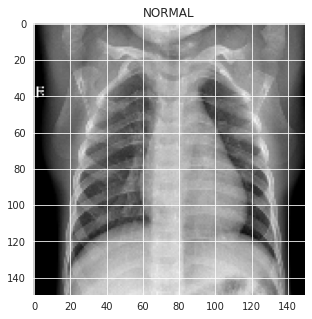

In [7]:
# Previewing images of both classes

plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap = 'gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap = 'gray')
plt.title(labels[train[-1][1]])

In [8]:
# Split data into images and labels for each set, so we can normalize the images

x_train = []
y_train = []

x_test = []
y_test = []

x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in test:
  x_test.append(feature)
  y_test.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)


In [9]:
# We perform a greyscale normalisation to reduce the effect of illumination differences
# the CNN converges faster on [0..1] than [0..255]

x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255
x_val = np.array(x_val) / 255


In [10]:
# Grayscale images need to be reshaped as RBG images for Densenet201 model. 
# Reshape the data to the correct dimensions (-1,150,150,3) for Densenet201 

x_train = x_train.reshape(-1, img_size, img_size, 1)
x_train = np.repeat(x_train, 3, -1)
y_train = np.array(y_train)

x_test = x_test.reshape(-1, img_size, img_size, 1)
x_test = np.repeat(x_test, 3, -1)
y_test = np.array(y_test)

x_val = x_val.reshape(-1, img_size, img_size, 1)
x_val = np.repeat(x_val, 3, -1)
y_val = np.array(y_val)

In [11]:
# Artificially expand dataset using ImageDataGenerator 

datagen = ImageDataGenerator(
    featurewise_center = False, 
    samplewise_center = False, 
    featurewise_std_normalization = False, 
    samplewise_std_normalization = False,
    zca_whitening = False,
    rotation_range = 30,
    zoom_range = 0.2, 
    width_shift_range = 0.1, 
    height_shift_range = 0.1, 
    horizontal_flip = True, 
    vertical_flip = False)

datagen.fit(x_train)

In [12]:
# Densenet201 Model 

densenet_model = DenseNet201(
    include_top = False,
    weights = 'imagenet', 
    input_tensor = None, 
    input_shape = (150,150,3), 
    pooling = None
)

densenet_model.trainable = True

for layer in densenet_model.layers:
  if 'conv5' in layer.name:
    layer.trainable = True
  else:
    layer.trainable = False

input = Input(shape = (150,150,3))
preprocess = Lambda(lambda x: tf.image.resize(x, (150, 150)), name='lamb')(input)
initializer = he_normal(seed=32)

layer = densenet_model(inputs=preprocess)
layer = Flatten()(layer)
layer = BatchNormalization()(layer)
layer = Dense(units=256, activation='relu', kernel_initializer=initializer)(layer)
layer = Dropout(0.5)(layer)
layer = BatchNormalization()(layer)
layer = Dense(units=128, activation='relu', kernel_initializer=initializer)(layer)
layer = Dropout(0.4)(layer)
layer = Dense(units=64, activation='relu', kernel_initializer=initializer)(layer)
layer = Dropout(0.3)(layer)
layer = Dense(units=1,activation='sigmoid',kernel_initializer=initializer)(layer)

model = Model(inputs=input, outputs=layer)

model.summary()

model.compile(loss='binary_crossentropy',
            optimizer= 'adam',
            metrics=['accuracy'])




74842112/74836368 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
lamb (Lambda)                (None, 150, 150, 3)       0         
_________________________________________________________________
densenet201 (Functional)     (None, 4, 4, 1920)        18321984  
_________________________________________________________________
flatten (Flatten)            (None, 30720)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30720)             122880    
_________________________________________________________________
dense (Dense)                (None, 256)               7864576   
______________________________________________________________

In [13]:
# Train Model 

history = model.fit(
    datagen.flow(x_train, y_train, batch_size = 32), 
    epochs = 12, 
    validation_data = datagen.flow(x_val, y_val))

Epoch 1/12
163/163 [==============================] - 616s 4s/step - loss: 0.3708 - accuracy: 0.8480 - val_loss: 0.8713 - val_accuracy: 0.7500
Epoch 2/12
163/163 [==============================] - 605s 4s/step - loss: 0.1745 - accuracy: 0.9369 - val_loss: 0.7684 - val_accuracy: 0.5625
Epoch 3/12
163/163 [==============================] - 607s 4s/step - loss: 0.1377 - accuracy: 0.9511 - val_loss: 0.6243 - val_accuracy: 0.6250
Epoch 4/12
163/163 [==============================] - 604s 4s/step - loss: 0.1204 - accuracy: 0.9582 - val_loss: 1.3965 - val_accuracy: 0.6250
Epoch 5/12
163/163 [==============================] - 605s 4s/step - loss: 0.1120 - accuracy: 0.9608 - val_loss: 0.3183 - val_accuracy: 0.8125
Epoch 6/12
163/163 [==============================] - 610s 4s/step - loss: 0.1069 - accuracy: 0.9634 - val_loss: 0.7041 - val_accuracy: 0.5000
Epoch 7/12
163/163 [==============================] - 605s 4s/step - loss: 0.1123 - accuracy: 0.9603 - val_loss: 0.4048 - val_accuracy: 0.7500

In [24]:
# Save model 	
model.save('Densenet201_Pneumonia.h5')

In [25]:
# Evaluating the model on the test data

# Resize test images to input into Model (150, 150, 3) -> (32, 32, 3) 
#x_test = tf.image.resize(x_test, (32, 32))

print("Loss of the model is - ", model.evaluate(x_test, y_test)[0])
print("Accuracy of the model is - ", model.evaluate(x_test, y_test)[1]*100, "%")

20/20 [==============================] - 51s 3s/step - loss: 0.1975 - accuracy: 0.9439
Loss of the model is -  0.19752554595470428
20/20 [==============================] - 52s 3s/step - loss: 0.1975 - accuracy: 0.9439
Accuracy of the model is -  94.39102411270142 %


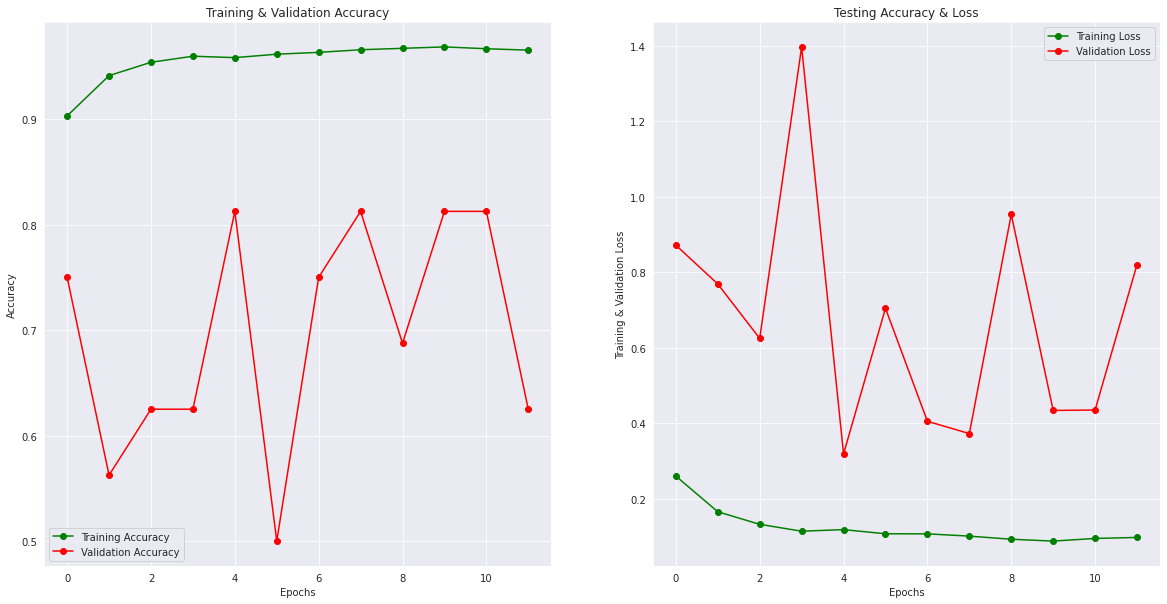

In [26]:
# Create Accuracy and Loss charts

epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title("Training & Validation Loss")
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [32]:
# Print predictions for first 15 images in the testset. 

predictions = model.predict(x_test)
predictions = np.where(predictions > 0.5, 1,0)
predictions[:15]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [33]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)', 'Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.93      0.98      0.96       390
   Normal (Class 1)       0.96      0.88      0.92       234

           accuracy                           0.94       624
          macro avg       0.95      0.93      0.94       624
       weighted avg       0.94      0.94      0.94       624



In [34]:
# Create confusion matrix

cm = confusion_matrix(y_test, predictions)
cm 

array([[382,   8],
       [ 27, 207]])

In [35]:
cm = pd.DataFrame(cm, index = ['0', '1'], columns = ['0', '1'])

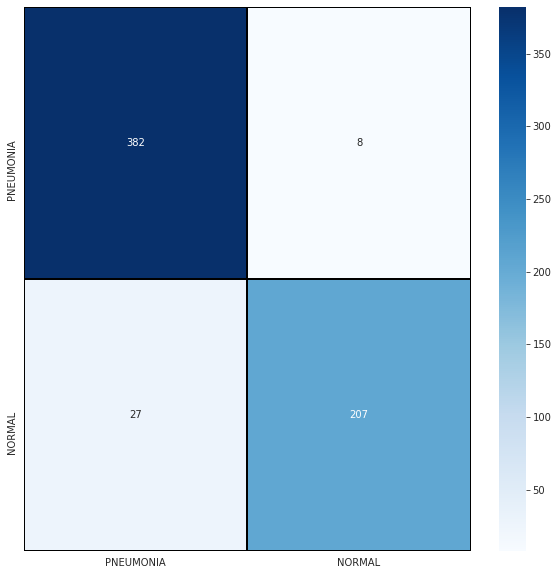

In [36]:
# Confusion matrix plot

plt.figure(figsize = (10,10))
sns.heatmap(
    cm, 
    cmap = 'Blues', 
    linecolor = 'black', 
    linewidth = 1, 
    annot = True, 
    fmt = '', 
    xticklabels = labels, 
    yticklabels = labels)

In [51]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

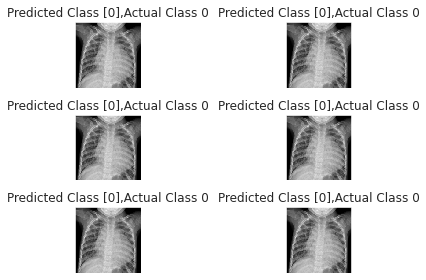

In [44]:
# Sample of correctly predicted classes

i = 0
for c in correct[:6]:
  plt.subplot(3,2,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_test[c].reshape(150,150,3), cmap="gray", interpolation='none')
  plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
  plt.tight_layout()
  i += 1

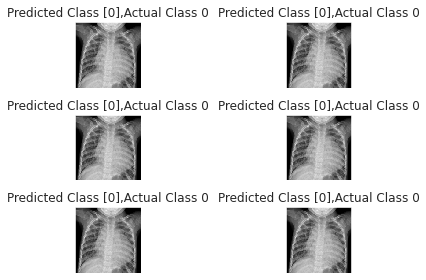

In [45]:
# Sample of incorrectly predicted classes 

i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150,3), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

In [ ]:
# Avoid disconnection from Google Colab when idle

while True:pass